In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[CpuDevice(id=0)]


# Process Data

In [6]:
c_df, r_df, d_df = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)
c_df.columns = pd.to_datetime(c_df.columns)
d_df.columns = pd.to_datetime(d_df.columns)

[265, 252, 83]


In [7]:
t_df, h_df, w_df = transform.weather(update=False)

In [8]:
d_df

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,11,14,14,15,15,18,18,21,23,25
Albania,0,0,0,0,0,0,0,0,0,0,...,21,22,22,23,23,23,23,23,24,25
Algeria,0,0,0,0,0,0,0,0,0,0,...,173,193,205,235,256,275,293,313,326,336
Andorra,0,0,0,0,0,0,0,0,0,0,...,21,22,23,25,26,26,29,29,31,33
Argentina,0,0,0,0,0,0,0,0,0,0,...,48,56,63,72,82,83,90,97,102,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,0,0,0,0,0,0,0,0,0,0,...,5373,6159,7097,7978,8958,9875,10612,11329,12107,12868
US,0,0,0,0,0,0,0,0,0,0,...,10783,12722,14695,16478,18586,20463,22020,23529,25832,28326
Australia,0,0,0,0,0,0,0,0,0,0,...,40,45,50,51,54,57,60,61,62,63


In [9]:
tests_df = pd.read_csv('../data/test_rate/test_rate_processed.csv', index_col='Country/Region')
tests_df.columns = pd.to_datetime(tests_df.columns)

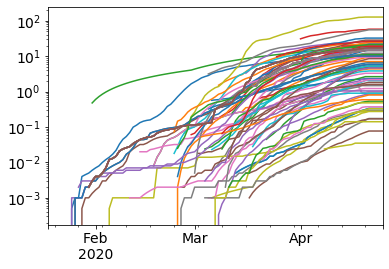

In [10]:
tests_df.T.plot(legend=False, logy=True)

In [11]:
all_countries = tests_df.index.intersection(d_df.index)

In [12]:
len(all_countries)

60

In [13]:
cases = {}
deaths = {}
temps = {}
hums = {}
testsp1k = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    climate_delay = 28    # days between infection and death
    if start_days[i]<climate_delay:
        climate_delay = start_days[i]
    if country not in all_countries:
        continue
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            time_slice = slice(start_days[i]-climate_delay, end_days[i]-climate_delay)
            temps[country] = np.nanmean(t_df.T[country].values[time_slice])
            hums[country] = np.nanmean(h_df.T[country].values[time_slice])
            cases[country] = c_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            testsp1k[country] = tests_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            if np.isnan(np.nanmax(testsp1k[country])):
                del deaths[country]
                del testsp1k[country]
        else:
            temps[country] = np.nanmean(t_df.T[country].values[start_days[i]-climate_delay:])
            hums[country] = np.nanmean(h_df.T[country].values[start_days[i]-climate_delay:])
            cases[country] = c_df[d_df.columns[start_days[i]:]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:]].T[country].values
            testsp1k[country] = tests_df[d_df.columns[start_days[i]:]].T[country].values
            if np.isnan(np.nanmax(testsp1k[country])):
                del deaths[country]
                del testsp1k[country]

In [14]:
len(deaths)

55

In [37]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]
countries = onp.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]
t0 = np.mean(samples['t0'], axis=0)

# t0_21 = 21*np.ones_like(t0)

t0_dict = dict(zip(countries, t0.astype(np.int32)))

In [45]:
# Ecuador shows to have greater than 100% positive rate. MORE POSITIVES than TESTS
all_countries = list(set(deaths.keys()).intersection(countries[t0>10]) - set(['Ecuador']))

In [46]:
len(all_countries)

43

In [47]:
pops = transform.population()
posp1k = {}
posrate = {}
for c in deaths.keys():
    posp1k[c] = cases[c][-1]/pops[c].values*1000
    posrate[c] = posp1k[c]/np.nanmean(testsp1k[c])*100

[265, 252, 265]
Number of unmatched regions : 75
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [48]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json', 'r'))

In [109]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json', 'r'))
new_bcg = {}
for key in bcg_cov_est.keys():
    if ('China / ' in key) or ('Canada / ' in key) or ('Australia / ' in key):
        continue
    else:
        new_bcg[key] = bcg_cov_est[key]            
        
new_bcg = pd.DataFrame(new_bcg, index=('BCG Coverage',))

In [110]:
new_bcg

,Burundi,Comoros,Djibouti,Eritrea,Kenya,Madagascar,Malawi,Mauritius,Mozambique,Seychelles,...,Lebanon,Taiwan*,Iran,Burma,"Korea, South",Russia,Syria,Tanzania,Vietnam,US
BCG Coverage,73.493385,63.1123,45.711255,57.842158,70.81676,57.307609,77.156602,49.404459,67.910886,55.39955,...,0.0,88.796064,56.528216,50.34247,51.302462,29.243126,60.97949,86.343602,52.788885,0.0


In [49]:
print(f'Missing BCG Coverage for : {set(all_countries)-set(bcg_cov_est.keys())}')
all_countries = list(set(all_countries).intersection(bcg_cov_est.keys()))

Missing BCG Coverage for : {'Bolivia'}


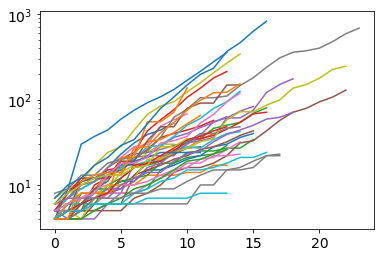

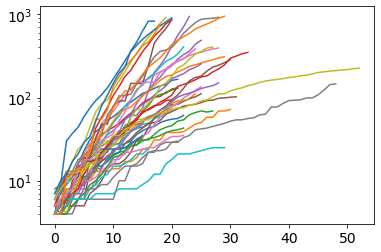

In [50]:
for c in all_countries:
    plt.semilogy(deaths[c][:t0_dict[c]])
plt.figure()
for c in all_countries:
    plt.semilogy(deaths[c])

In [51]:
len(all_countries)

42

# Bayesian Model

In [23]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [24]:
def model():
    
    N = len(all_countries)
    
    Di = normalHP('Di', 7.0, 3.0, N)
    GR = normalHP('GR', 1.2, 0.2, N)
#     BCG Coverage coefficient
    alpha = numpyro.sample('alpha', dist.Normal(0.0, 0.01))
#     Temperature coefficient
    beta = numpyro.sample('beta', dist.Normal(0.0, 0.01))
#     Humidity coefficient
    gamma = numpyro.sample('gamma', dist.Normal(0.0, 0.01))
#     Test Rate coefficient
    delta = numpyro.sample('delta', dist.Normal(0.0, 0.01))
#     Positive Test Rate coefficient
    epsilon = numpyro.sample('epsilon', dist.Normal(0.0, 0.01))

    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country][:t0_dict[c]]
        t = np.arange(len(dead))
        GR_ = alpha*bcg_cov_est[country] + beta*temps[country] + \
              gamma*hums[country] + delta*np.nanmax(testsp1k[country]) + \
              epsilon*posrate[country]
        prediction = Di[i]*(GR[i]+GR_)**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [25]:
N = len(all_countries)

scale = 0.5

init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
               'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
               'GR_ind': 1.2*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'alpha': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
               'beta': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
               'gamma': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
               'delta': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
               'epsilon': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model, dense_mass=True)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [ ]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

In [ ]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.6.4_21_day_MultiVariate_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
mcmc.print_summary()

In [53]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.6.1_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [59]:
with open('Results.csv', 'w') as fp:
    fp.write('Country | GR0 | theta_1 (bcg_cov) | theta_2 (temperature) | theta_3 (humidity) | theta_4 (tests/1k) | theta_5 (positives/100test) | GR_T')
    for i, c in enumerate(all_countries):
        GR = np.mean(samples['GR_ind'][:,i] + samples['alpha']*bcg_cov_est[c] + \
                      samples['beta']*temps[c] + samples['gamma']*hums[c] + \
                      samples['delta']*np.nanmax(testsp1k[c]) + samples['epsilon']*posrate[c])
        GR0, theta1 = np.mean(samples['GR_ind'][:,i]), np.mean(samples['alpha'])
        theta2, theta3 = np.mean(samples['beta']), np.mean(samples['gamma'])
        theta4, theta5 = np.mean(samples['delta']), np.mean(samples['epsilon']),
        fp.write(f'\n{c} | {GR0} | {theta1} | {theta2} | {theta3} | {theta4} | {theta5} | {GR}')

In [94]:
GR = {}
GR0 = {}
for i, c in enumerate(all_countries):
    gr0 = np.mean(samples['GR_ind'][:,i])
    gr0_std = np.std(samples['GR_ind'][:,i])
    
    gr = np.mean(samples['GR_ind'][:,i] + samples['alpha']*bcg_cov_est[c] + \
                  samples['beta']*temps[c] + samples['gamma']*hums[c] + \
                  samples['delta']*np.nanmax(testsp1k[c]) + samples['epsilon']*posrate[c])    
    gr_std = np.std(samples['GR_ind'][:,i] + samples['alpha']*bcg_cov_est[c] + \
                    samples['beta']*temps[c] + samples['gamma']*hums[c] + \
                    samples['delta']*np.nanmax(testsp1k[c]) + samples['epsilon']*posrate[c])
    GR[c] = [float(gr), float(gr_std)]
    GR0[c] = [float(gr0), float(gr0_std)]
#     print(f'[{c}, {GR}],')

In [89]:
1.2**7

3.583180799999999

In [93]:
np.log(gr)*14 + 1

DeviceArray(2.712881, dtype=float32)

### GR0

In [61]:
pd.read_csv('Results.csv', sep='|')

,Country,GR0,theta_1 (bcg_cov),theta_2 (temperature),theta_3 (humidity),theta_4 (tests/1k),theta_5 (positives/100test),GR_T
0,Czechia,1.290705,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.214775
1,Pakistan,1.186206,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.102676
2,Luxembourg,1.166108,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.052005
3,Netherlands,1.278678,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.292633
4,Canada / Quebec,1.273882,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.254058
5,Argentina,1.212052,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.124418
6,Austria,1.236668,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.185657
7,Japan,1.218243,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.157410
8,Germany,1.397493,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.348263
9,Finland,1.294238,-0.000006,-0.002528,-0.001411,-0.00123,0.003133,1.219900


# Trace Plots

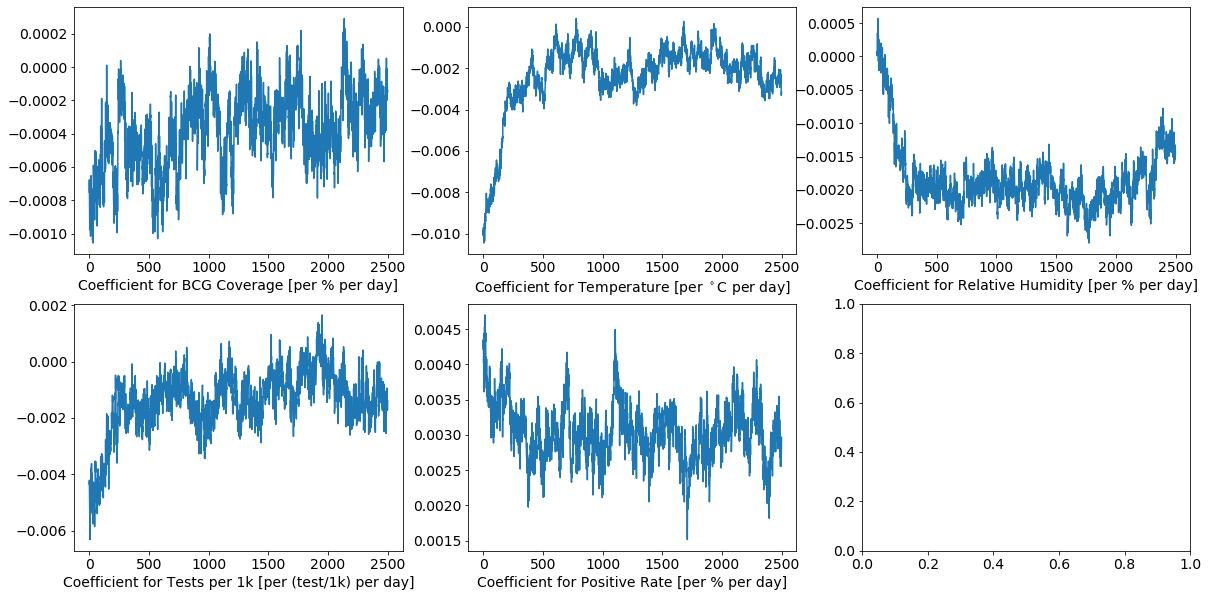

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    a[i].plot(samples[param])
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')

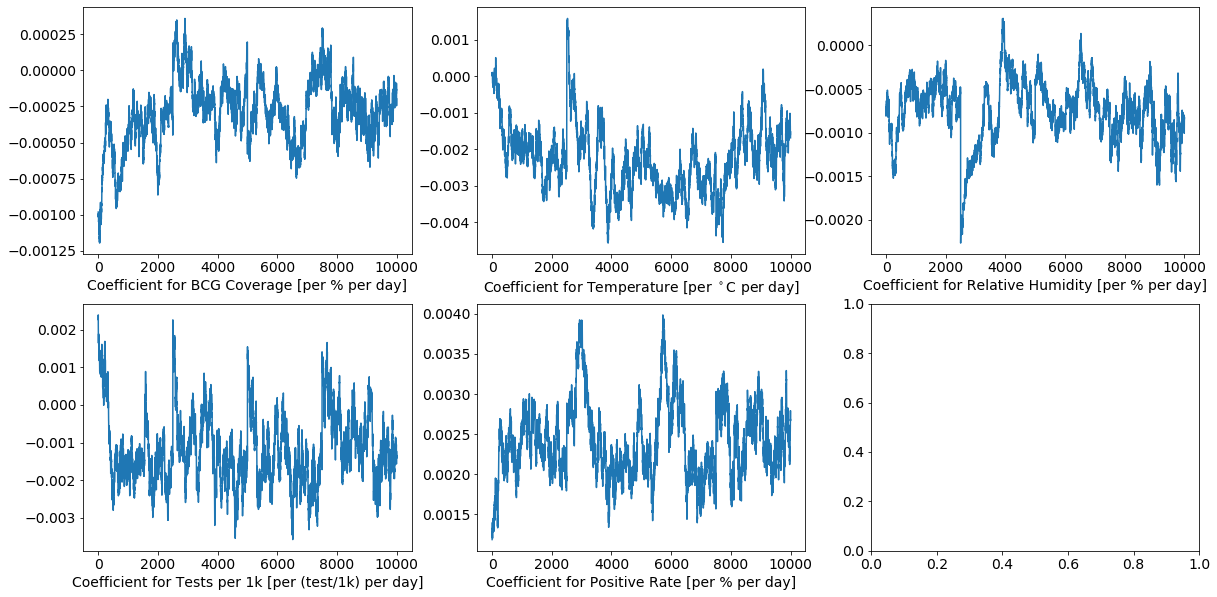

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    a[i].plot(samples[param])
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')

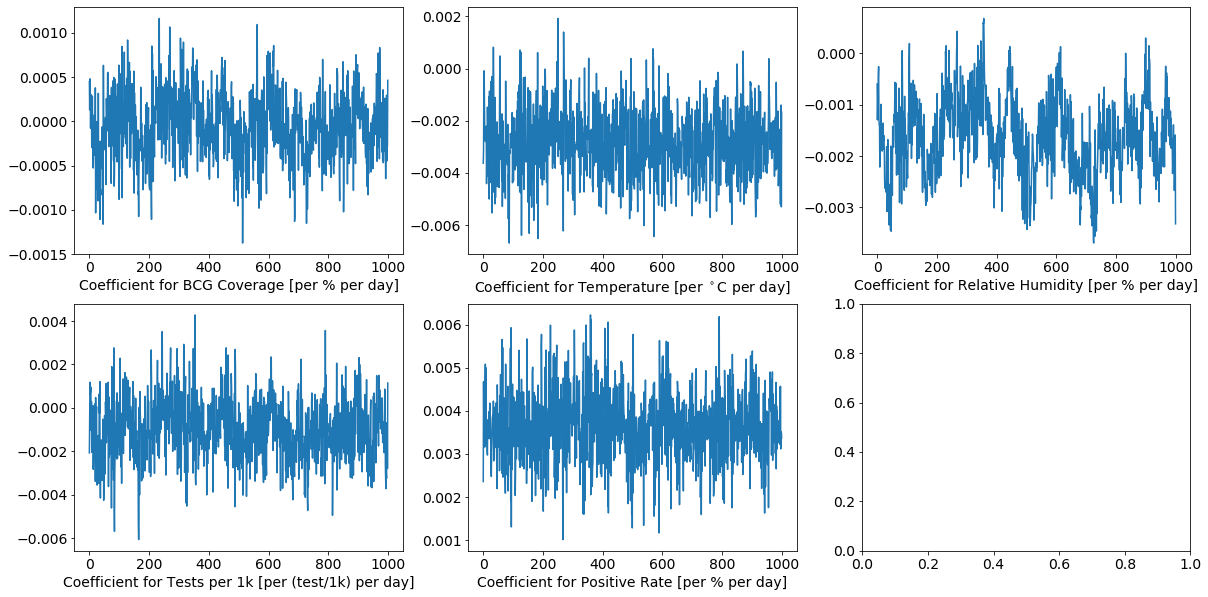

In [66]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    a[i].plot(samples[param])
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')

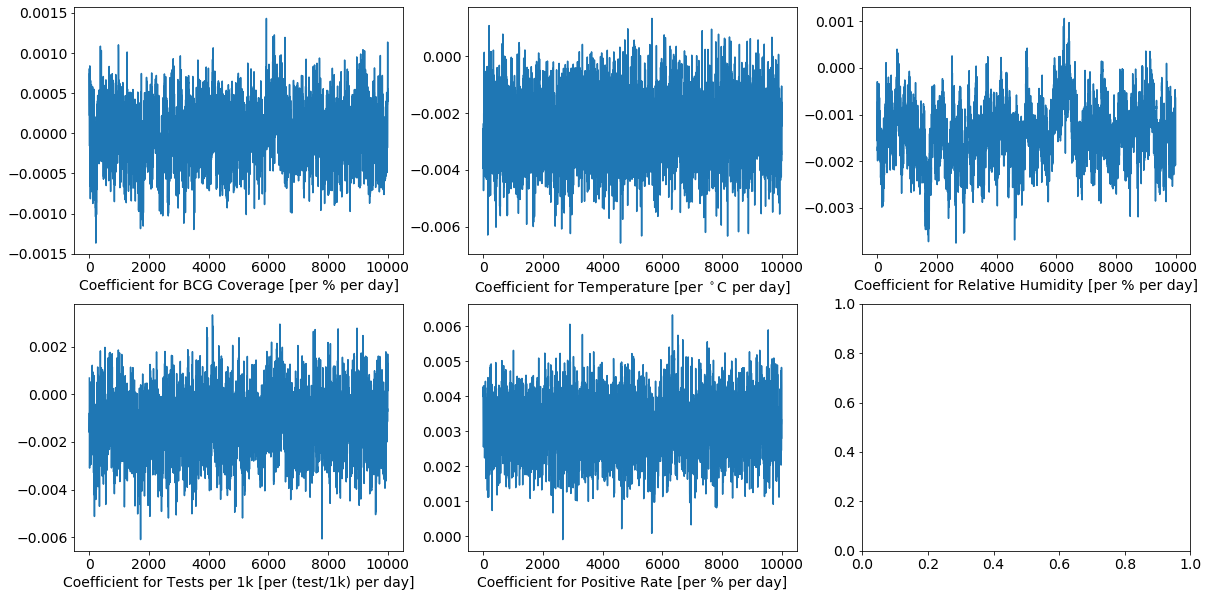

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    a[i].plot(samples[param])
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')

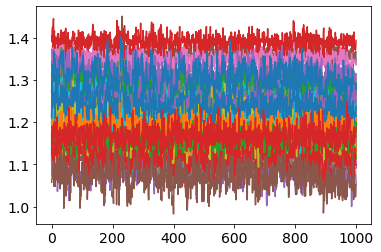

In [30]:
plt.plot(samples['GR_ind']);

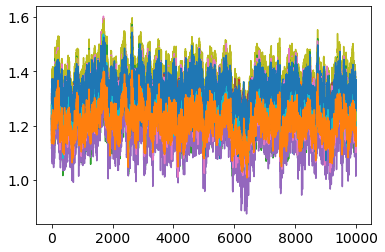

In [33]:
plt.plot(samples['GR_ind']);

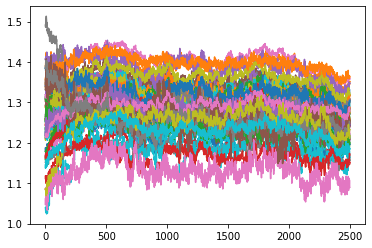

In [33]:
plt.plot(samples['GR_ind']);

# Parameter Marginals

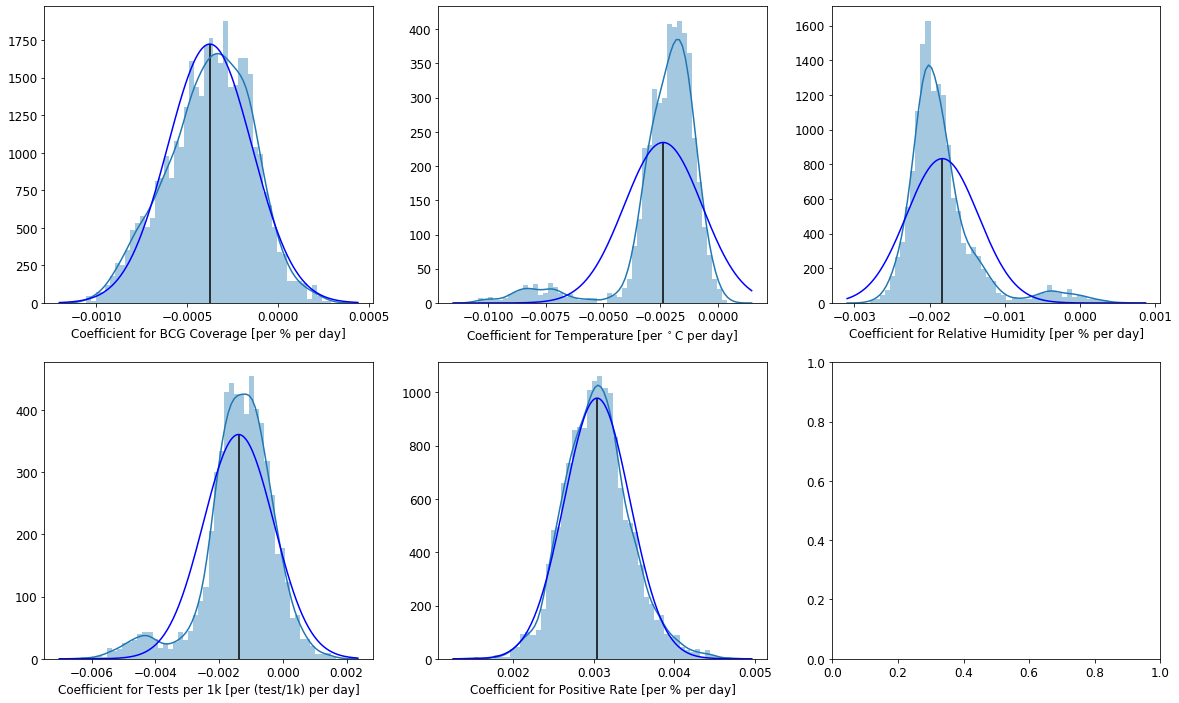

In [30]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    sns.distplot(samples[param], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples[param]), 0, norm.pdf(np.mean(samples[param]), *norm.fit(samples[param])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

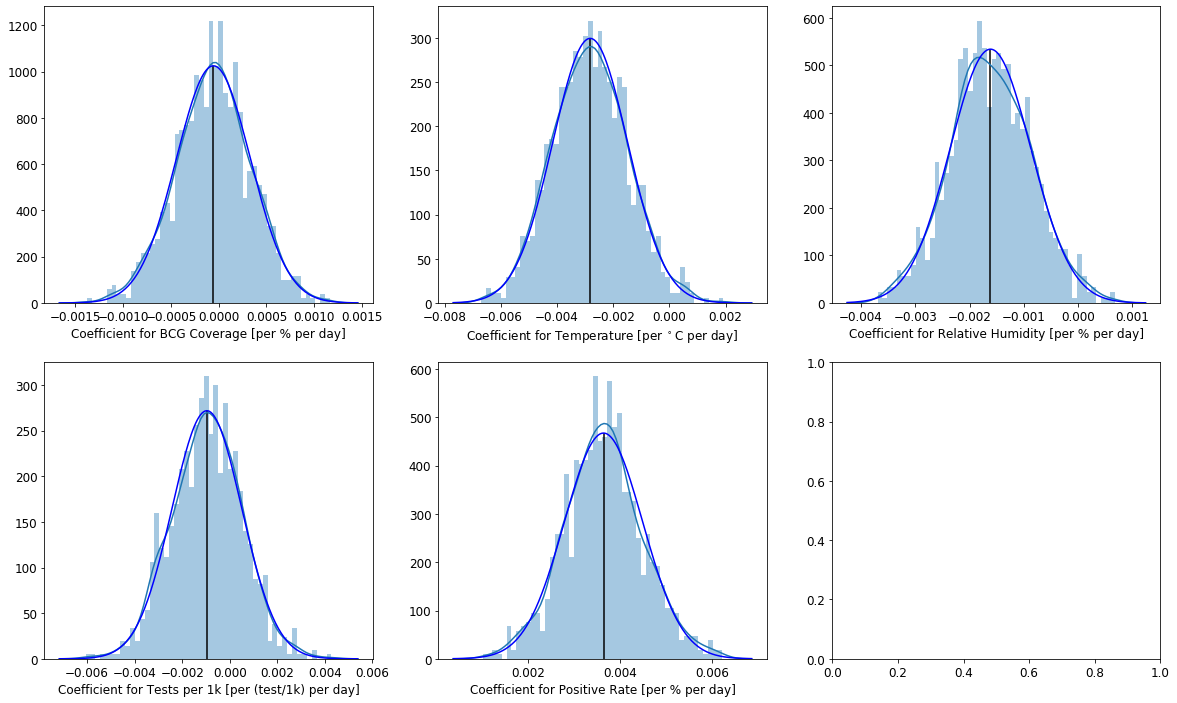

In [72]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    sns.distplot(samples[param], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples[param]), 0, norm.pdf(np.mean(samples[param]), *norm.fit(samples[param])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

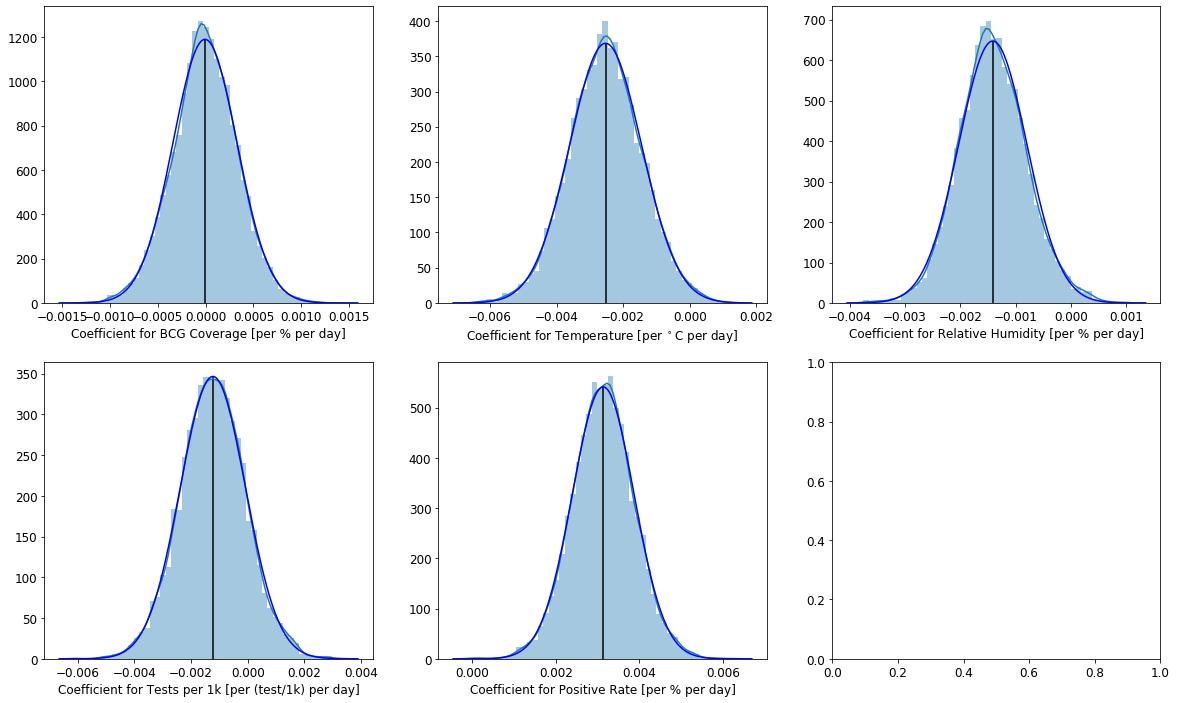

In [34]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
a = ax.flatten()
params = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%']
for i, param in enumerate(params):
    sns.distplot(samples[param], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples[param]), 0, norm.pdf(np.mean(samples[param]), *norm.fit(samples[param])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

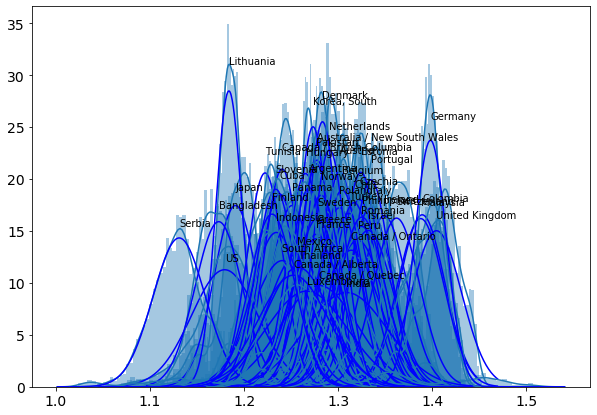

In [31]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

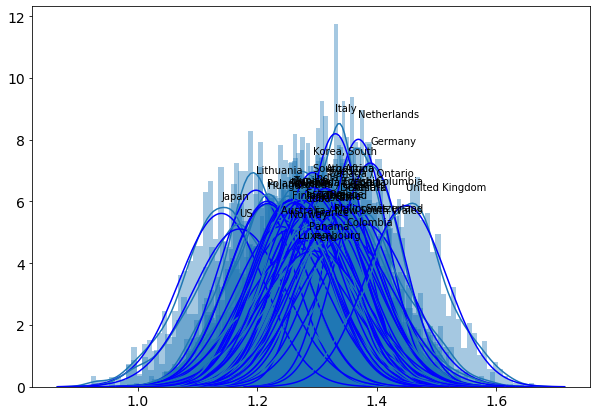

In [71]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

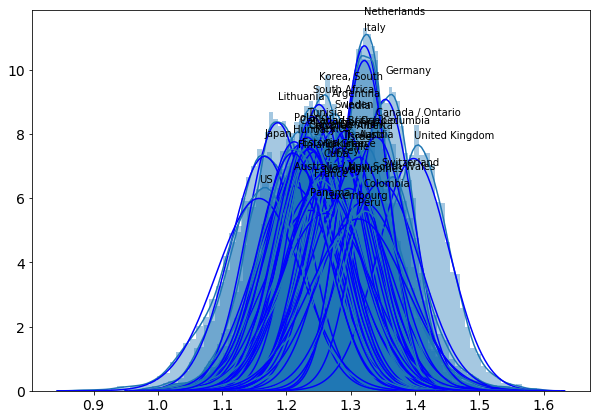

In [35]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

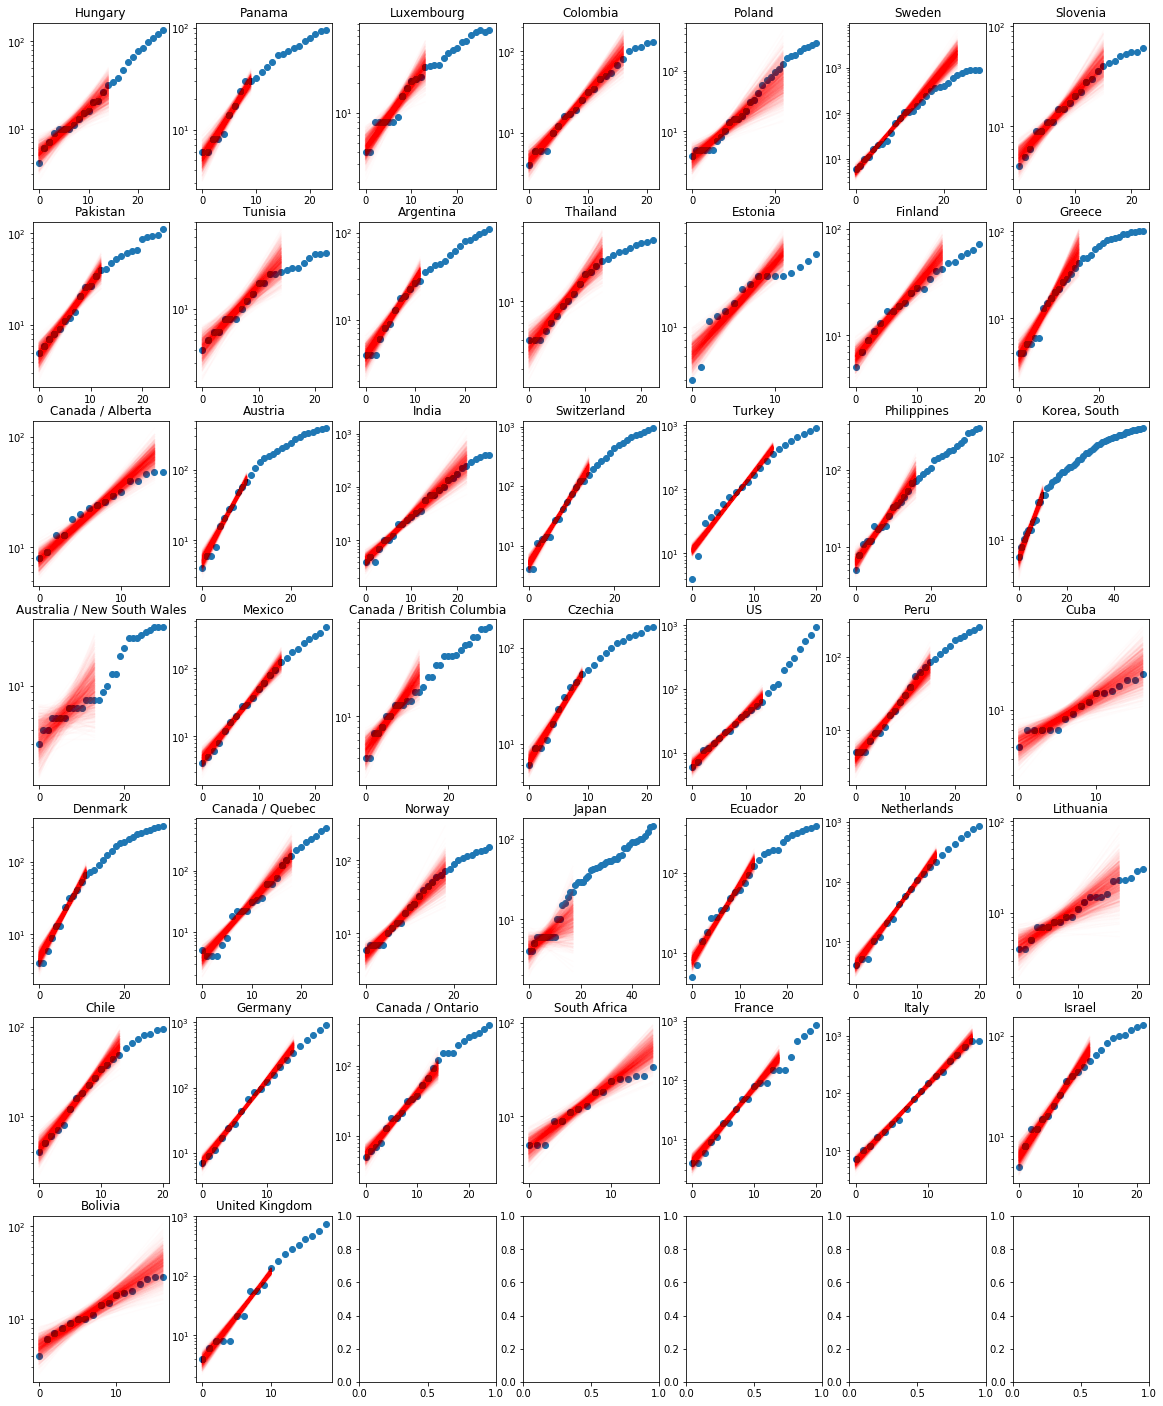

In [30]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    t = np.arange(len(deaths[c]))[:t0_dict[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    GR_ = alpha*bcg_cov_est[country] + beta*temps[country] + \
          gamma*hums[country] + delta*np.nanmax(tests[country]) + \
          epsilon*posrate[country]
    prediction = Di[i]*(GR[i]+GR_)**t
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*np.nanmax(tests[c]))**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14